In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import model.sdes as sdes
import model.discrete_diffusers as discrete_diffusers
import model.branch_definer as branch_definer
from plot.plot import plot_mnist_digits
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Create the data loader

In [3]:
samples_per_digit = 100
dataset = torchvision.datasets.FashionMNIST(
    "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
)

classes = torch.unique(dataset.targets).cpu().numpy()
digits_by_class = {}
for c in classes:
    mask = dataset.targets == c
    digits = (dataset.data[mask] / 256 * 2) - 1
    sample_inds = torch.tensor(np.random.choice(len(digits), size=samples_per_digit, replace=False))
    digits_by_class[c] = digits[sample_inds][:, None].to(DEVICE)
input_shape = (1, 28, 28)

In [4]:
# Create the diffusers
diffuser = sdes.VariancePreservingSDE(0.1, 20, input_shape)

t_limit = 1

### Plotting functions

In [5]:
def plot_forward_diffusion(diffused_digits_by_class, times):
    """
    Plots example digits and the trajectory of the forward diffusion
    process.
    Arguments:
        `diffused_digits_by_class`: the output of
            `branch_definer.run_forward_diffusion`
        `times`: array of times that diffusion was performed at
    """
    # Plot some results over time
    inds_to_show = np.arange(0, len(times), len(times) // 15)
    inds_to_show = np.concatenate([inds_to_show, [len(times) - 1]])
    num_classes = len(diffused_digits_by_class)
    num_show_per_class = 3
    example_value = next(iter(diffused_digits_by_class.values()))
    batch_size, input_shape = example_value.shape[1], example_value.shape[2:]
    for t_i in inds_to_show:
        t = times[t_i]
        digits_to_show = np.empty((num_classes * num_show_per_class,) + input_shape)
        
        for c_i, c in enumerate(sorted(diffused_digits_by_class.keys())):
            # Sample digits
            inds = np.random.choice(
                diffused_digits_by_class[c].shape[1], size=num_show_per_class, replace=False
            )
            digits_to_show[c_i * num_show_per_class : (c_i + 1) * num_show_per_class] = \
                diffused_digits_by_class[c][t_i][inds].cpu().numpy()

        # Reshape:
        digits_to_show = digits_to_show.reshape(
            (num_classes, num_show_per_class) + digits_to_show.shape[1:]
        )
        digits_to_show = np.swapaxes(digits_to_show, 0, 1).reshape((-1,) + digits_to_show.shape[2:])
            
        plot_mnist_digits(digits_to_show, grid_size=(num_classes, num_show_per_class), title=("t = %.2f" % t))

    # Show distribution over time
    fig, ax = plt.subplots(figsize=(20, 8))
    bins = np.linspace(-4, 4, 1000)
    cmap = plt.get_cmap("magma")
    for t_i in tqdm.notebook.trange(len(times)):
        all_vals = np.concatenate([
            np.random.choice(np.ravel(digits[t_i].cpu().numpy()), size=100, replace=False)
            for digits in diffused_digits_by_class.values()
        ])
        ax.hist(all_vals, bins=bins, histtype="step", color=cmap(t_i / len(times)), alpha=0.5, density=True)
    prior = diffuser.sample_prior(batch_size, torch.ones(batch_size).to(DEVICE) * times[-1]).cpu().numpy()
    ax.hist(np.ravel(prior), bins=bins, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
    ax.set_xlabel("x")
    ax.set_ylabel("p(x)")
    ax.set_title("Evolution of p(x) over forward SDE")
    ax.set_ylim((0, 3))
    plt.legend()
    plt.show()

In [6]:
def plot_similarities(sim_matrix, classes):
    """
    Plots the similarities between classes.
    Arguments:
        `sim_matrix`: a T x C x C similarity matrix between classes
            at various time points, output by
            `branch_definer.compute_time_similarities`
        `classes`: list of classes matching the order in `sim_matrix`
    """
    # Plot initial pairwise similarities
    labels = np.array(["%s-%s" % (classes[i], classes[j]) for i in range(len(classes)) for j in range(i + 1)])
    sims = np.array([sim_matrix[0, i, j] for i in range(len(classes)) for j in range(i + 1)])
    inds = np.flip(np.argsort(sims))
    labels, sims = labels[inds], sims[inds]
    fig, ax = plt.subplots(figsize=(20, 4))
    ax.bar(labels, sims)
    ax.set_ylabel("Average similarity")
    ax.set_title("Average similarity between pairs of classes (t = 0)")
    plt.show()
                
    # Plot average similarity over time
    mean_sims = []
    triu_inds = np.triu_indices(len(classes))
    for t_i in range(len(sim_matrix)):
        mean_sims.append(np.mean(sim_matrix[t_i][triu_inds]))
    fig, ax = plt.subplots(figsize=(20, 4))
    ax.plot(mean_sims)
    ax.set_xlabel("t")
    ax.set_ylabel("Average similarity")
    ax.set_title("Average similarity over all classes during forward diffusion")
    plt.show()

### Compute branch definitions

Forward-diffusing class 0
Forward-diffusing class 1
Forward-diffusing class 2
Forward-diffusing class 3
Forward-diffusing class 4
Forward-diffusing class 5
Forward-diffusing class 6
Forward-diffusing class 7
Forward-diffusing class 8
Forward-diffusing class 9


  0%|          | 0/1000 [00:00<?, ?it/s]

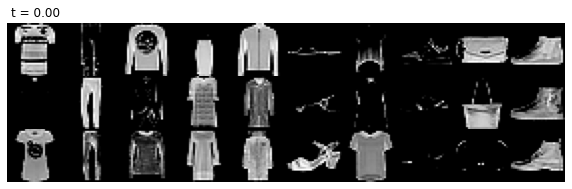

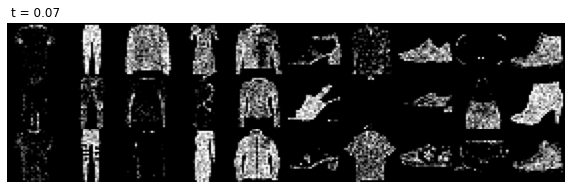

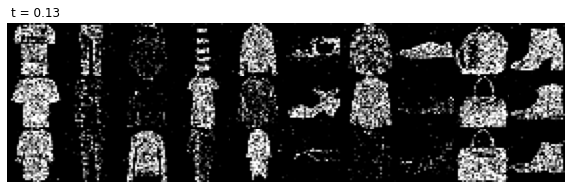

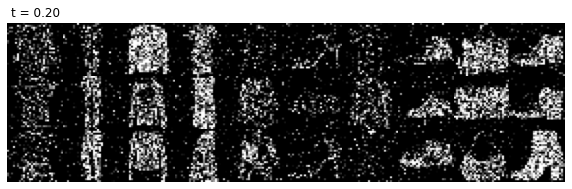

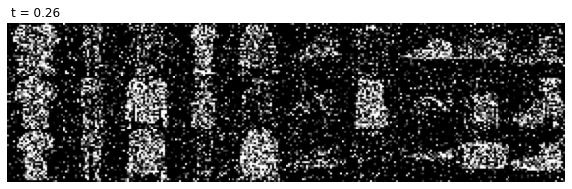

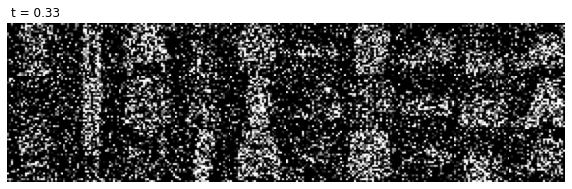

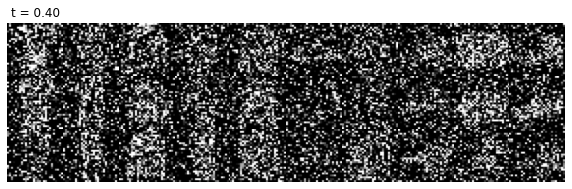

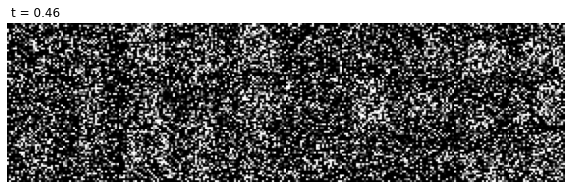

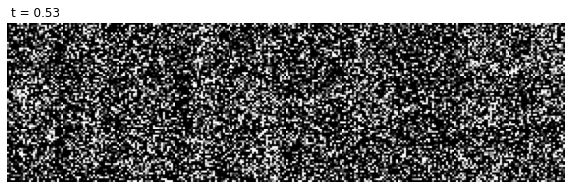

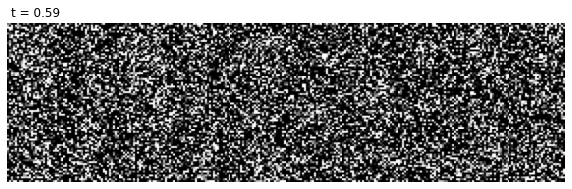

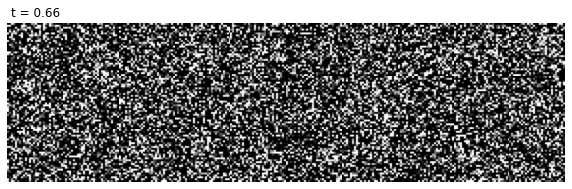

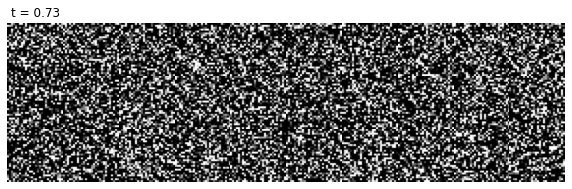

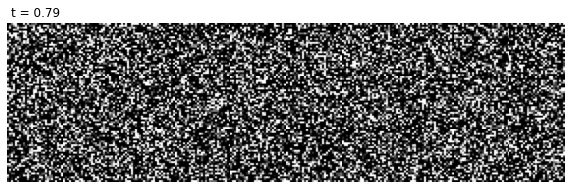

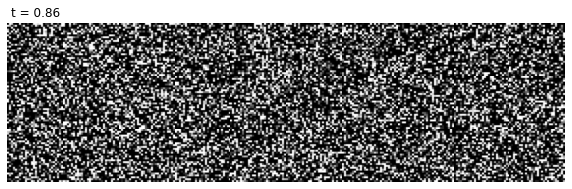

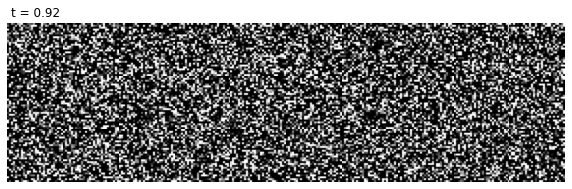

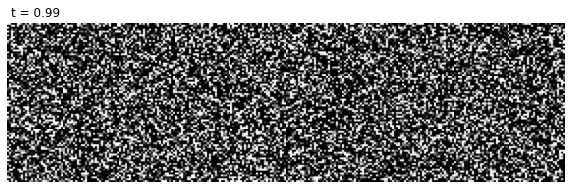

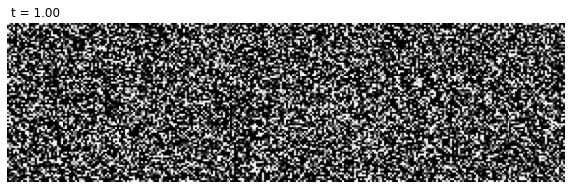

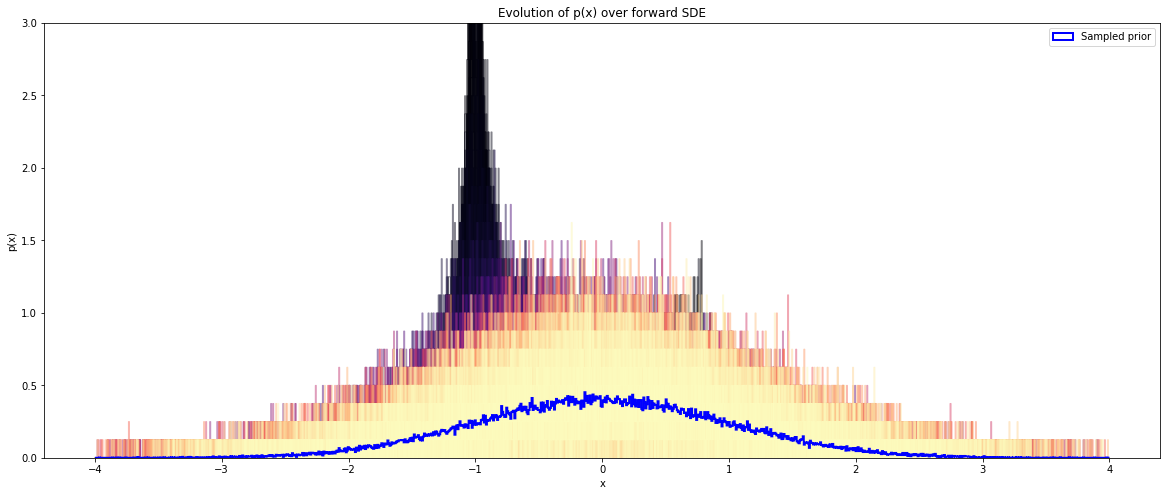

100%|████████████████████████████████████████████████████████████████| 1000/1000 [02:04<00:00,  8.01it/s]


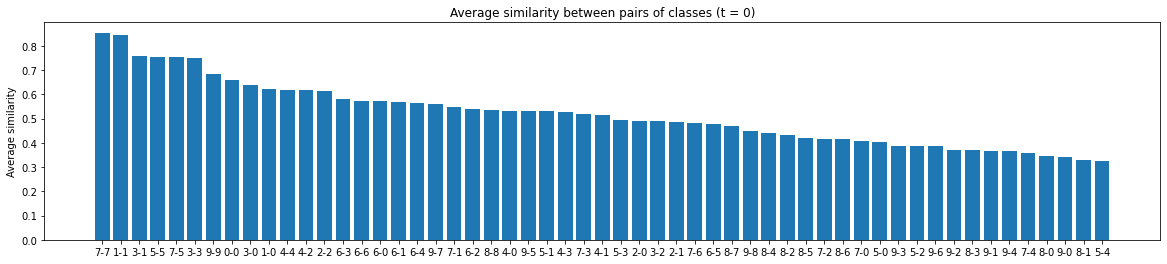

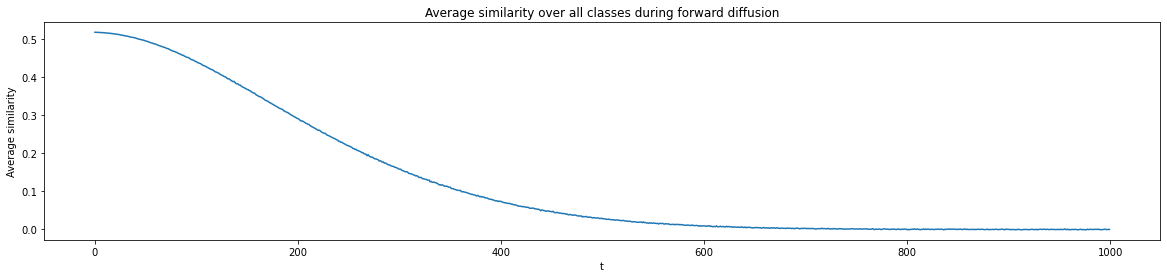

[(0.05, (4,), (2,)), (3.4934934934934936e-01, (2, 4), (6,)), (0.3943943943943944, (2, 4, 6), (0,)), (0.4294294294294294, (5,), (7,)), (0.43243243243243246, (0, 2, 4, 6), (3,)), (0.4364364364364364, (0, 2, 3, 4, 6), (1,)), (0.5085085085085085, (0, 1, 2, 3, 4, 6), (8,)), (0.5365365365365365, (5, 7), (0, 1, 2, 3, 4, 6, 8)), (0.5395395395395395, (0, 1, 2, 3, 4, 5, 6, 7, 8), (9,))]

[((0, 1, 2, 3, 4, 5, 6, 7, 8, 9), 0.5395395395395395, 1), ((0, 1, 2, 3, 4, 5, 6, 7, 8), 0.5365365365365365, 0.5395395395395395), ((0, 1, 2, 3, 4, 6, 8), 0.5085085085085085, 0.5365365365365365), ((0, 1, 2, 3, 4, 6), 0.4364364364364364, 0.5085085085085085), ((0, 2, 3, 4, 6), 0.43243243243243246, 0.4364364364364364), ((5, 7), 0.4294294294294294, 0.5365365365365365), ((0, 2, 4, 6), 0.3943943943943944, 0.43243243243243246), ((2, 4, 6), 0.34934934934934936, 0.3943943943943944), ((2, 4), 0.05, 0.34934934934934936), ((9,), 0, 0.5395395395395395), ((8,), 0, 0.5085085085085085), ((1,), 0, 0.4364364364364364), ((3,), 0, 0.

In [7]:
times = np.linspace(0, t_limit, 1000)
diffused_digits_by_class = branch_definer.run_forward_diffusion(
    digits_by_class, diffuser, times
)
plot_forward_diffusion(diffused_digits_by_class, times)
sim_matrix, sim_matrix_classes = branch_definer.compute_time_similarities(diffused_digits_by_class, times)
plot_similarities(sim_matrix, sim_matrix_classes)
branch_points = branch_definer.compute_branch_points(sim_matrix, times, sim_matrix_classes, epsilon=0.005, min_branch_time=0.1)
branch_defs = branch_definer.branch_points_to_branch_defs(branch_points, t_limit)
print(branch_points)
print()
print(branch_defs)

In [10]:
import json
classes = list(range(10))
with open("/gstore/home/tsenga5/branched_diffusion/data/config/classes_branch_points/fmnist/all_classes_minb10.json", "w") as f:
    json.dump({"classes": classes, "branches": [[[int(x) for x in b[0]], b[1], b[2]] for b in branch_defs]}, f, indent=4)